In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import linregress, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf

import geopandas as gpd
import networkx as nx
import math

from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas 
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [4]:
cbsa_shape = gpd.read_file("./tl_2024_us_cbsa/tl_2024_us_cbsa.shp")
cbsa_shape['cbsacode'] = cbsa_shape['GEOID'].astype('int')
# cbsa_shape

state_shape = gpd.read_file('./tl_2020_us_state/tl_2020_us_state.shp')
# state_shape.head()

df_cbsa = pd.read_csv("./df_cbsa.csv")
df_cbsa = df_cbsa.iloc[:,1:]
df_cbsa = df_cbsa.drop(['geometry','Unnamed: 0'], axis=1) 
df_cbsa

,cbsacode,cbsatitle,GDP_2019,ADDICTION MEDICINE,ADULT CONGENITAL HEART DISEASE (ACHD),ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY,ALLERGY/IMMUNOLOGY,ANESTHESIOLOGY,ANESTHESIOLOGY ASSISTANT,CARDIAC ELECTROPHYSIOLOGY,...,VASCULAR SURGERY,msa_name,Population,log_Population,Population_density,state,State,log_GDP,entropy_diversity,entropy_diversity_normalized
0,12020,"Athens-Clarke County, GA",10749088.0,1,0,2,14,76,60,7,...,9,"Athens-Clarke County, GA",222060,12.310703,8.365077e-05,GA,GA,16.190331,3.350564,0.771343
1,12060,"Atlanta-Sandy Springs-Roswell, GA",447126476.0,67,2,73,165,1482,1433,177,...,271,"Atlanta-Sandy Springs-Roswell, GA",6307261,15.657212,2.803753e-04,GA,GA,19.918352,3.461685,0.773157
2,12100,"Atlantic City-Hammonton, NJ",20131563.0,1,0,4,4,75,0,12,...,11,"Atlantic City-Hammonton, NJ",369823,12.820780,2.570403e-04,NJ,NJ,16.817799,3.373032,0.788706
3,12140,"Auburn, IN",2662923.0,0,0,0,0,7,0,0,...,0,"Auburn, IN",44198,10.696435,4.703256e-05,IN,IN,14.794935,3.071777,0.821843
4,12180,"Auburn, NY",3008173.0,1,0,0,2,26,0,1,...,2,"Auburn, NY",74485,11.218353,4.158407e-05,NY,NY,14.916843,3.235575,0.787077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,49020,"Winchester, VA-WV",474380.0,4,0,0,3,62,0,5,...,15,"Winchester, VA-WV",147260,11.899955,5.350129e-05,WV,WV,13.069764,3.325270,0.799558
841,49080,"Winnemucca, NV",1307649.0,0,0,0,0,1,0,0,...,0,"Winnemucca, NV",17136,9.748937,6.862763e-07,NV,NV,14.083741,2.934976,0.890510
842,49100,"Winona, MN",2423058.0,1,0,1,1,16,0,2,...,1,"Winona, MN",49721,10.814183,3.065808e-05,MN,MN,14.700541,3.374667,0.849980
843,49180,"Winston-Salem, NC",36213845.0,7,0,6,30,241,0,40,...,31,"Winston-Salem, NC",695630,13.452573,1.336895e-04,NC,NC,17.404952,3.257748,0.743434


<Axes: >

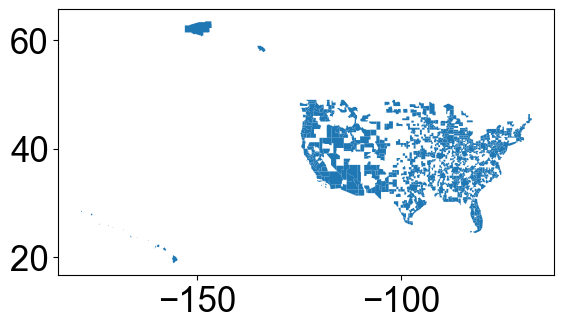

In [25]:
df_cbsa_spatial = cbsa_shape[['cbsacode','geometry']].merge(df_cbsa, on='cbsacode') 
df_cbsa_spatial.plot()

In [26]:
COUNTY2CBSA = pd.read_csv('./cbsa2county.csv')

ctyrank = pd.read_excel("./2020 County Health Rankings Data - v2.xlsx", sheet_name="Ranked Measure Data")
# ctyrank = ctyrank[['cbsacode','College']].drop_duplicates(subset=['cbsacode'])
new_header = ctyrank.iloc[0] 
ctyrank = ctyrank[1:]
ctyrank.columns = new_header
ctyrank

ctyrank['FIPS'] = ctyrank['FIPS'].astype('int')
county_college = ctyrank[['FIPS','# Some College']].merge(COUNTY2CBSA[['FIPS','cbsacode']], on='FIPS')
cbsa_college = county_college.groupby('cbsacode').agg({'# Some College':sum}).reset_index()
cbsa_college['College'] = cbsa_college['# Some College'].astype('int')
cbsa_college

,cbsacode,# Some College,College
0,10100,7203,7203
1,10140,9171,9171
2,10180,25425,25425
3,10220,5840,5840
4,10300,13777,13777
...,...,...,...
913,49660,55074,55074
914,49700,26868,26868
915,49740,28406,28406
916,49780,11181,11181


In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Step 1: Create design matrix (add constant if needed)
df_combined = df_cbsa_spatial.merge(cbsa_college, on='cbsacode')
X = np.log(df_combined[["Population", "GDP_2019","College"]])
X = sm.add_constant(X)

# Step 2: Compute VIF for each column
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


X = np.log(df_combined[["Population_density", "GDP_2019","College"]])
X = sm.add_constant(X)

# Step 2: Compute VIF for each column
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

      feature         VIF
0       const  645.091013
1  Population   55.003901
2    GDP_2019   23.445936
3     College   69.253924
              feature         VIF
0               const  876.124174
1  Population_density    2.051938
2            GDP_2019   23.125704
3             College   24.280893


In [14]:
df_cbsa_spatial.columns.tolist()

['cbsacode',
 'geometry',
 'cbsatitle',
 'GDP_2019',
 'ADDICTION MEDICINE',
 'ADULT CONGENITAL HEART DISEASE (ACHD)',
 'ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY',
 'ALLERGY/IMMUNOLOGY',
 'ANESTHESIOLOGY',
 'ANESTHESIOLOGY ASSISTANT',
 'CARDIAC ELECTROPHYSIOLOGY',
 'CARDIAC SURGERY',
 'CARDIOVASCULAR DISEASE (CARDIOLOGY)',
 'CERTIFIED CLINICAL NURSE SPECIALIST (CNS)',
 'CERTIFIED NURSE MIDWIFE (CNM)',
 'CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)',
 'CHIROPRACTIC',
 'CLINICAL PSYCHOLOGIST',
 'CLINICAL SOCIAL WORKER',
 'COLORECTAL SURGERY (PROCTOLOGY)',
 'CRITICAL CARE (INTENSIVISTS)',
 'DENTAL ANESTHESIOLOGY',
 'DENTIST',
 'DERMATOLOGY',
 'DIAGNOSTIC RADIOLOGY',
 'EMERGENCY MEDICINE',
 'ENDOCRINOLOGY',
 'ENDODONTICS',
 'FAMILY PRACTICE',
 'GASTROENTEROLOGY',
 'GENERAL PRACTICE',
 'GENERAL SURGERY',
 'GERIATRIC MEDICINE',
 'GERIATRIC PSYCHIATRY',
 'GYNECOLOGICAL ONCOLOGY',
 'HAND SURGERY',
 'HEMATOLOGY',
 'HEMATOLOGY/ONCOLOGY',
 'HEMATOPOIETIC CELL TRANSPLANTATION AND CELLULAR 

In [28]:
Specialty_ALL = pd.read_csv("./Specialty_ALL.csv")
df_cbsa_spatial_all = df_cbsa_spatial.merge(Specialty_ALL[['cbsacode','Dss']], on='cbsacode')
df_cbsa_spatial_all

,cbsacode,geometry,cbsatitle,GDP_2019,ADDICTION MEDICINE,ADULT CONGENITAL HEART DISEASE (ACHD),ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY,ALLERGY/IMMUNOLOGY,ANESTHESIOLOGY,ANESTHESIOLOGY ASSISTANT,...,msa_name,Population,log_Population,Population_density,state,State,log_GDP,entropy_diversity,entropy_diversity_normalized,Dss
0,11660,"POLYGON ((-93.50221 34.21413, -93.50221 34.214...","Arkadelphia, AR",828301.0,0,0,0,0,0,0,...,"Arkadelphia, AR",21274,9.965241,0.000009,AR,AR,13.627132,2.037341,0.734815,0.186667
1,11700,"POLYGON ((-82.40860 35.81818, -82.40815 35.818...","Asheville, NC",20317731.0,4,0,1,12,107,0,...,"Asheville, NC",417202,12.941326,0.000079,NC,NC,16.827005,3.283684,0.753708,0.866667
2,11740,"POLYGON ((-82.22067 40.66736, -82.22112 40.667...","Ashland, OH",1844299.0,2,0,0,0,11,1,...,"Ashland, OH",52190,10.862646,0.000048,OH,OH,14.427610,3.211256,0.781161,0.320000
3,11820,"POLYGON ((-123.66230 45.77466, -123.67371 45.7...","Astoria, OR",1982996.0,1,0,1,0,0,0,...,"Astoria, OR",41102,10.623812,0.000019,OR,OR,14.500119,3.011638,0.805753,0.440000
4,11860,"POLYGON ((-95.09690 39.52782, -95.09270 39.524...","Atchison, KS",736162.0,0,0,2,0,0,0,...,"Atchison, KS",16016,9.681344,0.000014,KS,KS,13.509205,2.849359,0.795129,0.386667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,37740,"POLYGON ((-111.72073 34.16170, -111.72070 34.1...","Payson, AZ",1712477.0,0,0,0,1,7,0,...,"Payson, AZ",54003,10.896795,0.000004,AZ,AZ,14.353451,3.148607,0.793042,0.520000
841,37800,"POLYGON ((-93.09922 41.16087, -93.10304 41.160...","Pella, IA",2281932.0,0,0,0,0,0,0,...,"Pella, IA",33770,10.427328,0.000024,IA,IA,14.640533,3.011257,0.833931,0.373333
842,37860,"POLYGON ((-86.91833 30.21764, -86.92528 30.216...","Pensacola-Ferry Pass-Brent, FL",21931373.0,4,0,0,4,98,2,...,"Pensacola-Ferry Pass-Brent, FL",530090,13.180802,0.000123,FL,FL,16.903429,3.236269,0.754294,0.866667
843,37900,"POLYGON ((-89.04724 41.01330, -89.04724 41.012...","Peoria, IL",21416008.0,5,0,1,5,65,0,...,"Peoria, IL",362240,12.800062,0.000042,IL,IL,16.879649,3.274219,0.765601,0.880000


In [88]:
patient_data_ = pd.read_csv("./patient_data_.csv")
patient_data_.columns.tolist()
Specialty_ALL = pd.read_csv("./Specialty_ALL.csv")
df_cbsa_spatial_all = df_cbsa_spatial.merge(Specialty_ALL[['cbsacode','Dss','DN']], on='cbsacode')

cbsa_all = df_cbsa_spatial_all.merge(patient_data_[['cbsacode',
 'spend_mean',
 'spend_per_capita_mean',
 'vol_mean',
 'vol_per_capita_mean',
 'TOTAL_PROVIDER',
 'PROVIDER_PERCAPITA',
 'diabetes_spend_mean',
 'diabetes_vol_mean',
 'cvd_spend_mean',
 'cvd_vol_mean',
]], on=['cbsacode'])
cbsa_all

,cbsacode,geometry,cbsatitle,GDP_2019,ADDICTION MEDICINE,ADULT CONGENITAL HEART DISEASE (ACHD),ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY,ALLERGY/IMMUNOLOGY,ANESTHESIOLOGY,ANESTHESIOLOGY ASSISTANT,...,spend_mean,spend_per_capita_mean,vol_mean,vol_per_capita_mean,TOTAL_PROVIDER,PROVIDER_PERCAPITA,diabetes_spend_mean,diabetes_vol_mean,cvd_spend_mean,cvd_vol_mean
0,11660,"POLYGON ((-93.50221 34.21413, -93.50221 34.214...","Arkadelphia, AR",828301.0,0,0,0,0,0,0,...,5.267214e+06,242.904286,0.000000,1.622095,59.0,0.002773,3.631059e+06,4817.376,1.021977e+07,18338.598
1,11700,"POLYGON ((-82.40860 35.81818, -82.40815 35.818...","Asheville, NC",20317731.0,4,0,1,12,107,0,...,1.049448e+08,769.964643,572914.978550,4.598439,2736.0,0.006558,1.002387e+08,14304.533,2.631922e+08,45957.258
2,11740,"POLYGON ((-82.22067 40.66736, -82.22112 40.667...","Ashland, OH",1844299.0,2,0,0,0,11,1,...,1.318771e+07,250.964286,70888.188292,1.324196,117.0,0.002242,1.368939e+07,5423.521,3.727982e+07,14996.309
3,11820,"POLYGON ((-123.66230 45.77466, -123.67371 45.7...","Astoria, OR",1982996.0,1,0,1,0,0,0,...,1.036540e+07,253.006786,45262.905189,1.141389,243.0,0.005912,7.932628e+06,3889.664,1.872162e+07,11734.680
4,11860,"POLYGON ((-95.09690 39.52782, -95.09270 39.524...","Atchison, KS",736162.0,0,0,2,0,0,0,...,3.310071e+06,202.348929,0.000000,1.178427,129.0,0.008054,2.720194e+06,4202.481,6.842922e+06,13349.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,37740,"POLYGON ((-111.72073 34.16170, -111.72070 34.1...","Payson, AZ",1712477.0,0,0,0,1,7,0,...,1.390855e+07,260.436071,73990.403983,1.374111,361.0,0.006685,1.512961e+07,4127.101,3.916176e+07,14090.334
841,37800,"POLYGON ((-93.09922 41.16087, -93.10304 41.160...","Pella, IA",2281932.0,0,0,0,0,0,0,...,8.654095e+06,258.635000,42100.033329,1.268341,195.0,0.005774,6.693824e+06,4675.783,1.820002e+07,14856.739
842,37860,"POLYGON ((-86.91833 30.21764, -86.92528 30.216...","Pensacola-Ferry Pass-Brent, FL",21931373.0,4,0,0,4,98,2,...,1.125268e+08,450.055357,668635.830694,2.742321,2262.0,0.004267,9.585776e+07,8573.362,2.764649e+08,32325.379
843,37900,"POLYGON ((-89.04724 41.01330, -89.04724 41.012...","Peoria, IL",21416008.0,5,0,1,5,65,0,...,9.955418e+07,1393.022500,535410.182191,7.823871,2587.0,0.007142,7.658266e+07,21847.340,2.333069e+08,84466.644


In [89]:
cbsa_all.entropy_diversity_normalized

0      0.734815
1      0.753708
2      0.781161
3      0.805753
4      0.795129
         ...   
840    0.793042
841    0.833931
842    0.754294
843    0.765601
844    0.820107
Name: entropy_diversity_normalized, Length: 845, dtype: float64

PearsonRResult(statistic=-0.06939854992785022, pvalue=0.04371805267488664)


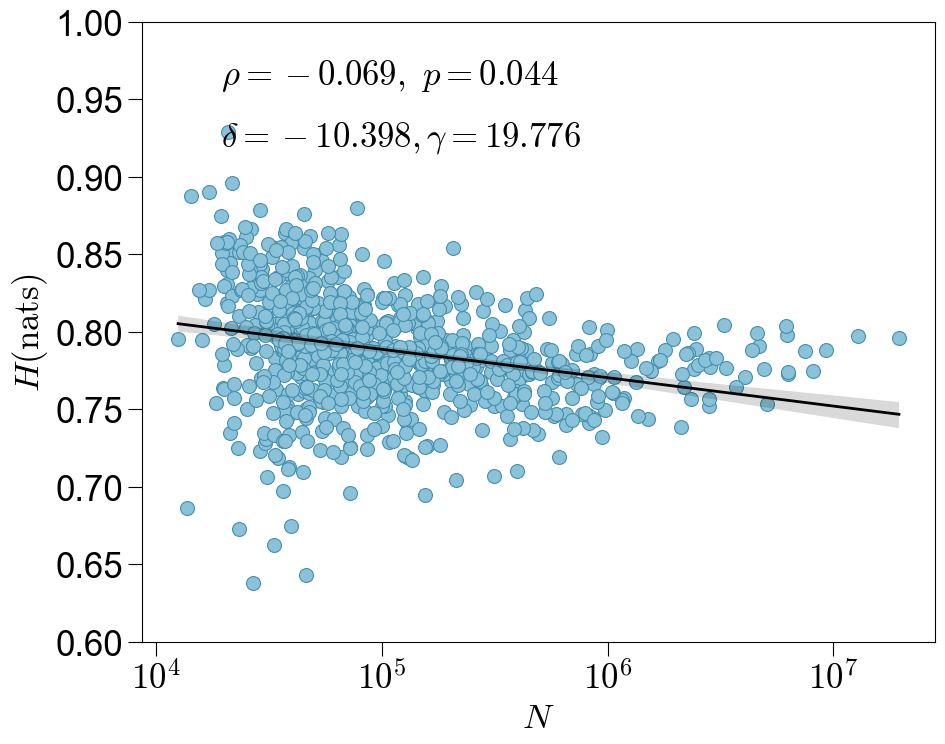

In [90]:
df_entropy = cbsa_all.copy()
fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams.update({
    'font.size' : 25,
    "lines.linewidth": 2,
    'lines.markersize':10,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "it",    
    "mathtext.rm"  : "arial",
        })

# plt.xscale('log')
sns.scatterplot(
                # size=df['Population'],
                # y=df['CVD_ENCOUNTER_PERPROVIDER'] - df['DIABETES_ENCOUNTER_PERPROVIDER'],
                y = df_entropy['entropy_diversity_normalized'],
                # y=df['PROVIDER_PERCAPITA'],
                # sizes=(15, 18000),
                x = np.log10(df_entropy['Population']),
                # s=150,
                # alpha=0.6,
                # palette='Blues',
                color='#89c2d9', s=100, edgecolor='#468faf',
                legend=False,
                # vmin=1,
                # vmax=5,
                ax=ax
                )
slope, intercept, _, _, _ = linregress(df_entropy['entropy_diversity_normalized'], np.log(df_entropy['Population']) )
delta = r'$\Delta$'
corr, pval = pearsonr(df_entropy['entropy_diversity_normalized'], df_entropy['Population'])
print(pearsonr(df_entropy['entropy_diversity_normalized'], df_entropy['Population']))
sns.regplot(y=df_entropy['entropy_diversity_normalized'], x=np.log10(df_entropy['Population']), 
             scatter=False,
            order=1,          # forces linear
    # lowess=False,     # disables local smoothing
     color='black', line_kws={'linewidth': 2}
     )

plt.text(.1, .9, r'$\rho={},\ p={}$'.format(str(np.round(corr,3)), str(np.round(pval,3))), transform=ax.transAxes,
         fontsize=25, color='black')#, bbox=dict(facecolor='white', alpha=0.7))
plt.text(0.1, .8, r'$\delta = {}, \gamma = {}$'.format(str(np.round(slope,3)), str(np.round(intercept,3))),  transform=ax.transAxes,
         fontsize=25, color='black')#, bbox=dict(facecolor='white', alpha=0.7))
plt.ylim(0.6,1)
xticks_log = np.log([10e4, 10e5, 10e6, 10e7])  # log-transformed positions
xtick_labels = [r'$10^4$',r'$10^5$', r'$10^6$', r'$10^7$']  # labels in scientific notation

ax.set_xticks([4, 5, 6, 7])
ax.set_xticklabels(xtick_labels)
plt.ylabel('$H(\mathrm{nats})$')
plt.xlabel(r'$N$')
plt.xticks(size=20)
plt.yticks(size=20)
plt.tick_params(axis='x', labelsize=25, length=10,)
plt.tick_params(axis='y', labelsize=25, length=10,)
plt.tight_layout()
# plt.savefig('./N_H.pdf', dpi=300, bbox_inches='tight')

# Economic clustering

Optimal K is: 3 with silhouette score of 0.7656


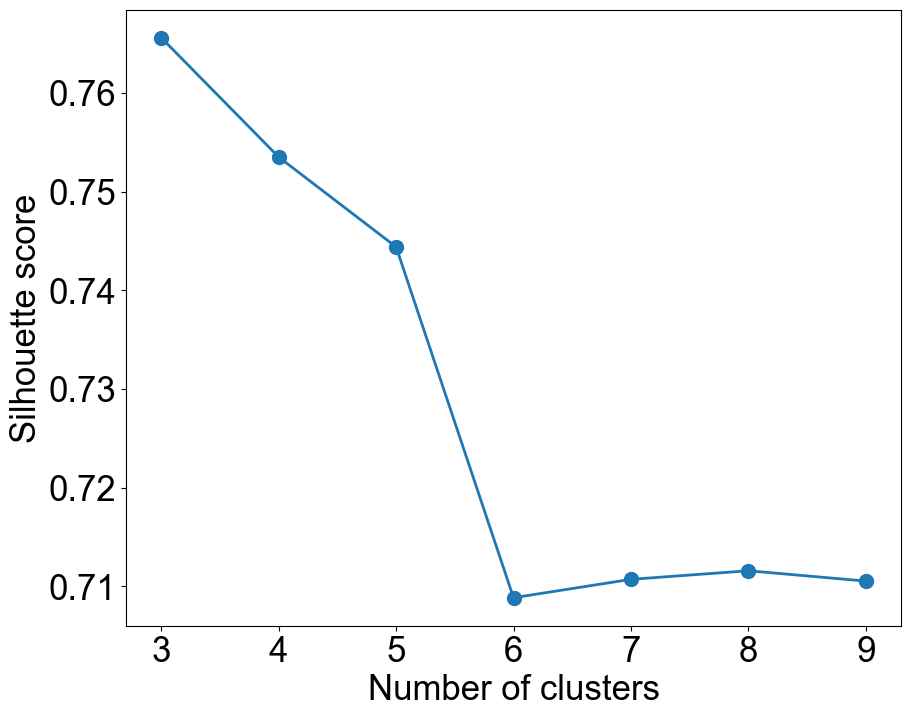

In [76]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# 1. Cluster cities by economic spending
# df_diversity = (df_entropy[['cbsacode',]]).copy()
# cbsa_final = cbsa_all.merge(df_diversity, on='cbsacode')
cbsa_final = cbsa_all.copy()
X_econ = StandardScaler().fit_transform(cbsa_final[['spend_per_capita_mean']])




### find the optimal K

from sklearn.metrics import silhouette_score

Ks = range(3, 10)
scores = {}
for K in Ks:
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X_econ)
    score = silhouette_score(X_econ, kmeans.labels_)
    scores[K] = score

optimal_K = max(scores, key=scores.get)
print(f"Optimal K is: {optimal_K} with silhouette score of {scores[optimal_K]:.4f}")

fig, ax = plt.subplots(figsize=(10, 8))

plt.rcParams.update({
    'font.size' : 25,
    "lines.linewidth": 2,
    'lines.markersize':10,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "it",    
    "mathtext.rm"  : "arial",
        })
plt.plot(list(scores.keys()), list(scores.values()), marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
# plt.title("Choosing Optimal K for Economic Clustering")
# plt.grid(True)
plt.show()


ANOVA F = 124.24, p = 0.0000
Kruskal-Wallis H = 188.660, p = 0.0000
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  High    Low  -0.4005    0.0   -0.52 -0.2811   True
  High Medium  -0.1148 0.0839 -0.2411  0.0116  False
   Low Medium   0.2858    0.0   0.238  0.3336   True
----------------------------------------------------
                High           Low        Medium
High    1.000000e+00  6.485462e-11  2.863545e-01
Low     6.485462e-11  1.000000e+00  2.200491e-34
Medium  2.863545e-01  2.200491e-34  1.000000e+00


/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_48370/4009999296.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


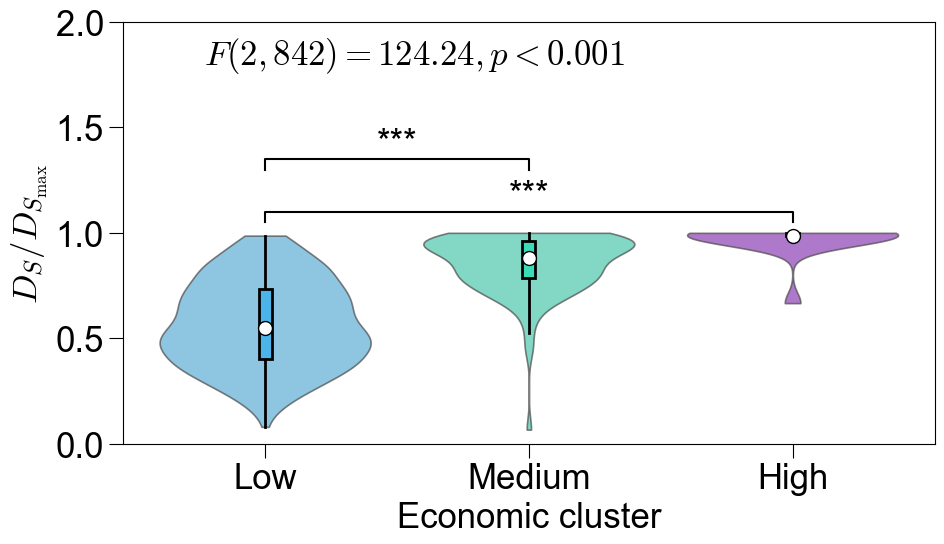

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from itertools import combinations
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import kruskal
import scikit_posthocs as sp


kmeans_econ = KMeans(n_clusters=optimal_K, random_state=0).fit(X_econ)
cbsa_final['econ_cluster'] = kmeans_econ.labels_
# Set your order of named clusters
order = ["Low", "Medium", "High"]

# Map numeric codes to named clusters
cbsa_final["econ_cluster_named"] = cbsa_final["econ_cluster"].map({1: "Low", 0: "Medium", 2: "High"})

# Run ANOVA
groups = [group["Dss"].values for _, group in cbsa_final.groupby("econ_cluster_named")]

f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F = {f_stat:.2f}, p = {p_val:.4f}")

stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.4f}")

# Tukey HSD test
tukey = pairwise_tukeyhsd(endog=cbsa_final["Dss"],
                          groups=cbsa_final["econ_cluster_named"],
                          alpha=0.05)
print(tukey.summary())

dunn_result = sp.posthoc_dunn(cbsa_final, val_col='Dss', group_col='econ_cluster_named', p_adjust='bonferroni')
print(dunn_result)

cbsa_new = cbsa_final.copy()

# Initialize figure
fig, ax = plt.subplots(figsize=(10, 6))
plt.rcParams.update({
    'font.size': 25,
    "lines.linewidth": 2,
    'lines.markersize': 10,
    "font.family": "arial",
    "mathtext.fontset": "cm",
    "mathtext.default": "it",
    "mathtext.rm": "arial",
})

colors = ["#4bb5ea", "#39dcb6", "#952cc9"]

# Violin plot
sns.violinplot(
    x="econ_cluster_named",
    y="Dss",
    data=cbsa_new,
    order=order,
    inner=None,
    linewidth=1.2,
    palette=colors,
    ax=ax,
    alpha=0.7,
    cut=0
)

# Add pairwise significance annotations
tukey_results = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
group_positions = {name: i for i, name in enumerate(order)}
max_y = cbsa_new["Dss"].max()
h = 0.1
step = 0.25
annot_count = 0

for idx, row in tukey_results.iterrows():
    g1, g2, pval, reject = row['group1'], row['group2'], row['p-adj'], row['reject']
    if reject:
        x1, x2 = group_positions[g1], group_positions[g2]
        y = max_y + step * annot_count
        ax.plot([x1, x1, x2, x2], [y + 0.05, y + h, y + h, y+0.05], lw=1.5, color='black')
        if pval < 0.001:
            text = '***'
        elif pval < 0.01:
            text = '**'
        elif pval < 0.05:
            text = '*'
        else:
            text = 'ns'
        ax.text((x1 + x2) / 2, y + h + 0.002, text, ha='center', va='bottom',)
        annot_count += 1

# Compute box components
q1 = cbsa_new.groupby("econ_cluster_named")["Dss"].quantile(0.25)
q3 = cbsa_new.groupby("econ_cluster_named")["Dss"].quantile(0.75)
medians = cbsa_new.groupby("econ_cluster_named")["Dss"].median()
iqr = q3 - q1
lower_whiskers = q1 - 1.5 * iqr
upper_whiskers = q3 + 1.5 * iqr
true_min = cbsa_new.groupby("econ_cluster_named")["Dss"].min()
true_max = cbsa_new.groupby("econ_cluster_named")["Dss"].max()
lower_whiskers = np.maximum(lower_whiskers, true_min)
upper_whiskers = np.minimum(upper_whiskers, true_max)

# Draw custom boxes and whiskers
box_width = 0.05
for i, name in enumerate(order):
    box_bottom = q1[name]
    box_top = q3[name]
    median = medians[name]
    whisker_min = lower_whiskers[name]
    whisker_max = upper_whiskers[name]
    ax.add_patch(Rectangle(
        (i - box_width / 2, box_bottom),
        box_width,
        box_top - box_bottom,
        facecolor=colors[i],
        edgecolor='black',
        linewidth=2,
        zorder=10
    ))
    ax.plot([i, i], [whisker_min, box_bottom], color='black', linewidth=2, zorder=9)
    ax.plot([i, i], [box_top, whisker_max], color='black', linewidth=2, zorder=9)

# Median white dot
for i, median in enumerate(medians.loc[order]):
    ax.scatter(i, median, color='white', edgecolor='black', s=100, zorder=10)

# ANOVA annotation
plt.text(.1, .9, r'$F(2, 842) = {}, p<0.001$'.format(str(np.round(f_stat, 2))), transform=ax.transAxes,
         fontsize=25, color='black')

# Labels and final settings
plt.xlabel("Economic cluster")
plt.ylabel(r"$D_{S}/D_{S_{\max}}$")
plt.yticks(size=20)
plt.ylim(0, 2)
plt.tick_params(axis='x', labelsize=25, length=10)
plt.tick_params(axis='y', labelsize=25, length=10)
plt.tight_layout()
# plt.savefig('./economic_clustering_total.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [55]:
print('Low',cbsa_final[cbsa_final['econ_cluster_named']=='Low'].spend_per_capita_mean.mean())
print('Medium',cbsa_final[cbsa_final['econ_cluster_named']=='Medium'].spend_per_capita_mean.mean())
print('High',cbsa_final[cbsa_final['econ_cluster_named']=='High'].spend_per_capita_mean.mean())

Low 315.132397044335
Medium 1236.765238095238
High 4282.552761904762


In [42]:
len(Specialty_ALL.columns[5:-80])
df_analysis = pd.read_csv("SCALING_RESULT.csv")
df_analysis

,Unnamed: 0,Specialty,Population_effect,CIs_betaN,Scaling_exponent,CI,R^2,Scaling_density,CI_density,Gini_SAMI,...,PageRank,katz_centrality,in_degree_centrality,out_degree_centrality,local_reaching_centrality,breadth_score,depth_score,CE_positive,CE_negative,new_reaching
0,0,ADDICTION MEDICINE,1.047778,"(0.8835897624391889, 1.2119665046439616)",0.305,"(0.2448968761941547, 0.3644647069176129)",0.38,0.372,"(0.2741901619067379, 0.470359845143777)",0.334321,...,0.017033,0.109982,0.013514,0.000000,0.000000,-1.000000,1.000000e+00,0.000000,1.000000,0.000000
1,1,PREVENTIVE MEDICINE,1.132855,"(0.9538825842831573, 1.31182733915826)",0.331,"(0.26493758011173496, 0.3965108309634293)",0.46,0.358,"(0.25751609002974885, 0.45796526054204634)",0.334491,...,0.009207,0.099984,0.000000,0.013514,0.013514,1.000000,-1.000000e+00,1.000000,0.000000,0.013514
2,2,OSTEOPATHIC MANIPULATIVE MEDICINE,1.088476,"(0.9232226097877911, 1.2537285375108678)",0.351,"(0.2828191182293869, 0.4196125968679856)",0.37,0.334,"(0.24408660757740724, 0.42310861306904274)",0.416298,...,0.014511,0.111092,0.013514,0.000000,0.000000,-0.733333,4.000000e+00,0.000000,0.733333,0.000000
3,3,MICROGRAPHIC DERMATOLOGIC SURGERY (MDS),1.399535,"(1.1935943760588676, 1.605475220862509)",0.379,"(0.31875874769630974, 0.43936469202118766)",0.49,0.361,"(0.24636475225803817, 0.47647187515054595)",0.311459,...,0.017033,0.109982,0.013514,0.000000,0.000000,-1.000000,1.000000e+00,0.000000,1.000000,0.000000
4,4,MAXILLOFACIAL SURGERY,1.249382,"(1.0623312210369087, 1.436433238055514)",0.398,"(0.3193439389529985, 0.4772718260029427)",0.39,0.475,"(0.3363737124021191, 0.6126334749622138)",0.398151,...,0.010772,0.109982,0.013514,0.000000,0.000000,-0.200000,1.000000e+00,0.000000,0.200000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,PHYSICIAN ASSISTANT,1.953378,"(0.9807421645385941, 2.9260131874875324)",1.057,"(1.017405777924903, 1.0956631504036)",0.72,0.888,"(0.8055572016419361, 0.9698560390429514)",0.386433,...,0.012468,0.119980,0.027027,0.000000,0.000000,-0.416667,1.000000e+00,0.000000,0.416667,0.000000
71,71,CLINICAL PSYCHOLOGIST,1.790953,"(1.4877074907730603, 2.094198330459331)",1.069,"(1.0258633829697972, 1.111415988465945)",0.73,0.916,"(0.8175749370447967, 1.0143065943342096)",0.428459,...,0.013772,0.119980,0.027027,0.040541,0.040541,2.416667,1.110223e-16,3.000000,0.583333,0.040541
72,72,PHYSICAL THERAPY,1.788588,"(1.20335105595949, 2.373823997160017)",1.089,"(1.052749186479573, 1.1262500604735801)",0.77,0.844,"(0.7546934175019402, 0.9341394131806187)",0.378567,...,0.012480,0.111082,0.013514,0.000000,0.000000,-0.466667,3.000000e+00,0.000000,0.466667,0.000000
73,73,INTERNAL MEDICINE,2.922746,"(1.5566779311440058, 4.288813130941828)",1.100,"(1.0715569486810836, 1.1283916880331968)",0.83,0.962,"(0.884677409845536, 1.0387433755892825)",0.310511,...,0.009207,0.099984,0.000000,0.229730,0.283784,13.702381,-1.196078e+00,13.702381,0.000000,0.281532


In [44]:

def scaling_iloc(x0,y0,name):
    # print(len(x0))
    samis = Get_SAMIs(x0,y0)
    # print("SAMIs = ",samis)
    # print("Var = ",np.round(np.var(samis),2))
    x = np.log(x0)
    Y = np.log(y0)
    X = sm.add_constant(x)
    model = sm.OLS(Y,X)
    fit = model.fit(cov_type='HC1')
    # print(fit.summary())
        
    intercept, slope = fit.params
    # print("intercept = ", np.round(intercept,2))
    # print("c = ", np.round(np.exp(intercept),3))

    x_0 =  np.sort(x0)[0]
    y_0 = np.exp(slope*np.log(x_0)+intercept)

    x_f = np.sort(x0)[-1]
    y_f = np.exp(slope*np.log(x_f)+intercept)
    y_null = np.exp(np.log(x_f)+intercept)

    beta = round(slope,3)
    R2 = str(round(fit.rsquared,2))
    # print(R2)
    # R2 = str(round(fit.pvalues[1],3))
    beta_lowerbound, beta_upper = fit.conf_int().iloc[1]
    beta_lowerbound = np.round(beta_lowerbound,2)
    beta_upper = np.round(beta_upper,2)
    return fit.conf_int().iloc[1,:],samis,beta,float(R2),fit

def Get_SAMIs(x0,y0):
    x = np.log(x0)
    y = np.log(y0)
    res = linregress(x,y)
    y_hat = res.intercept + res.slope*x
    SAMIs = y-y_hat
    return SAMIs


def all_upper(my_list): 
    return list(map(lambda x: x.upper(), my_list))


def scaling_weighted(x0,y0,name):
    # print(len(x0))
    samis = Get_SAMIs(x0,y0)
    # print("SAMIs = ",samis)
    # print("Var = ",np.round(np.var(samis),2))
    x = np.log(x0)
    Y = np.log(y0)
    
    errors = Y - np.mean(Y)
    error_variance = np.var(errors)
    weights = 1/error_variance

    X = sm.add_constant(x)
    model = sm.WLS(Y,X, weights=error_variance)
    fit = model.fit(cov_type='HC1')
    # print(fit.summary())
        
    intercept, slope = fit.params
    # print("intercept = ", np.round(intercept,2))
    # print("c = ", np.round(np.exp(intercept),3))

    x_0 =  np.sort(x0)[0]
    y_0 = np.exp(slope*np.log(x_0)+intercept)

    x_f = np.sort(x0)[-1]
    y_f = np.exp(slope*np.log(x_f)+intercept)
    y_null = np.exp(np.log(x_f)+intercept)

    beta = round(slope,3)
    R2 = str(round(fit.rsquared,2))
    # print(R2)
    # R2 = str(round(fit.pvalues[1],3))
    beta_lowerbound, beta_upper = fit.conf_int().iloc[1]
    beta_lowerbound = np.round(beta_lowerbound,2)
    beta_upper = np.round(beta_upper,2)


    return fit.conf_int().iloc[1,:],samis,beta,float(R2)


def get_FAMIs(x0,y0):
    """ 

    Parameters
    ----------
    x0: static variables of interest 
    
    Returns
    -------
    FAMIs: the residual of the multiple linear regression 
    coef: coefficients of the variables of interest from regression line
    """
    x = np.log(x0)

    y = np.log(y0)
    V = x.shape[1]

    X = sm.add_constant(x)
    # print(X.shape,y.shape)
    model = sm.OLS(y, X).fit(cov_type='HC1')
    coef = model.params[1:].tolist()
    # CI_low = model.conf_int(alpha=0.05, cols=None)[1:][0].tolist()
    # CI_high = model.conf_int(alpha=0.05, cols=None)[1:][1].tolist()

    y_pred = model.params[0]  + np.sum([model.params[v+1]*np.log(x0).iloc[:,v] for v in range(V)], axis=0)
    FAMIs = y-y_pred

    return FAMIs, coef,model




In [45]:

what = []

moranI_SAMIs = []
moranpsim_SAMIs = []
moranI_SAMIs_density = []
moranpsim_SAMIs_density = []



moranI_FAMIs = []
moranpsim_FAMIs = []
moranI_FAMIs_density = []
moranpsim_FAMIs_density = []

for s in df_analysis.Specialty.unique():
    print(s)
    if (df_combined[s]>0).astype(int).sum()>=100:
        what.append(s)

        df_pos = df_combined[df_combined[s]>0].copy()

        w = weights.Kernel.from_dataframe(df_pos,)
        # Row-standardization
        w.transform = "R"

        CI,SAMIs,beta,r2,model_SAMIs = scaling_iloc(df_pos["Population"],df_pos[s], s)


        # Define dependent and independent variables
        FAMIs,_,model_FAMIs = get_FAMIs(df_pos[['Population', 'GDP_2019','College']], df_pos[s]) # multiple predictors

        CI_density,SAMIs_density,beta_density,r2_density,model_SAMIs_density = scaling_iloc(df_pos["Population_density"],df_pos[s], s)

        FAMIs_density,_,model_FAMIs_density = get_FAMIs(df_pos[['Population_density', 'GDP_2019','College']], df_pos[s]) # multiple predictors

        df_pos['SAMIs'] = SAMIs
        df_pos['SAMIs_density'] = SAMIs_density


        moran_SAMIs = esda.moran.Moran(df_pos["SAMIs"], w)
        # print(moran_SAMIs.I, moran_SAMIs.p_sim)
        moran_SAMIs_density = esda.moran.Moran(df_pos["SAMIs_density"], w)
        # print(moran_SAMIs_density.I, moran_SAMIs_density.p_sim)

        moranI_SAMIs.append(moran_SAMIs.I)
        moranpsim_SAMIs.append(moran_SAMIs.p_sim)

        moranI_SAMIs_density.append(moran_SAMIs_density.I)
        moranpsim_SAMIs_density.append(moran_SAMIs_density.p_sim)

        df_pos['FAMIs'] = FAMIs
        df_pos['FAMIs_density'] = FAMIs_density



        moran_FAMIs = esda.moran.Moran(df_pos["FAMIs"], w)
        # print(moran_FAMIs.I, moran_FAMIs.p_sim)
        moran_FAMIs_density = esda.moran.Moran(df_pos["FAMIs_density"], w)
        # print(moran_FAMIs_density.I, moran_FAMIs_density.p_sim)

        moranI_FAMIs.append(moran_FAMIs.I)
        moranpsim_FAMIs.append(moran_FAMIs.p_sim)

        moranI_FAMIs_density.append(moran_FAMIs_density.I)
        moranpsim_FAMIs_density.append(moran_FAMIs_density.p_sim)




ADDICTION MEDICINE
PREVENTIVE MEDICINE
OSTEOPATHIC MANIPULATIVE MEDICINE
MICROGRAPHIC DERMATOLOGIC SURGERY (MDS)
MAXILLOFACIAL SURGERY
MARRIAGE AND FAMILY THERAPIST


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


NUCLEAR MEDICINE


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY
CERTIFIED CLINICAL NURSE SPECIALIST (CNS)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


SLEEP MEDICINE
HEMATOLOGY
ORAL SURGERY
ANESTHESIOLOGY ASSISTANT
CARDIAC SURGERY
GYNECOLOGICAL ONCOLOGY
INTERVENTIONAL PAIN MANAGEMENT
CERTIFIED NURSE MIDWIFE (CNM)
CARDIAC ELECTROPHYSIOLOGY
GENERAL PRACTICE


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


SPORTS MEDICINE


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


INTERVENTIONAL CARDIOLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


INTERVENTIONAL RADIOLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


MENTAL HEALTH COUNSELOR


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


HAND SURGERY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


SURGICAL ONCOLOGY
MEDICAL ONCOLOGY
HOSPICE/PALLIATIVE CARE


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


GERIATRIC MEDICINE


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


COLORECTAL SURGERY (PROCTOLOGY)
PAIN MANAGEMENT


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


QUALIFIED SPEECH LANGUAGE PATHOLOGIST
THORACIC SURGERY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


REGISTERED DIETITIAN OR NUTRITION PROFESSIONAL


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


ALLERGY/IMMUNOLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


VASCULAR SURGERY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


RADIATION ONCOLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


CRITICAL CARE (INTENSIVISTS)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


QUALIFIED AUDIOLOGIST


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


NEUROSURGERY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


PEDIATRIC MEDICINE


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


RHEUMATOLOGY
HEMATOLOGY/ONCOLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


NEPHROLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


PLASTIC AND RECONSTRUCTIVE SURGERY
CARDIOVASCULAR DISEASE (CARDIOLOGY)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


OCCUPATIONAL THERAPY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


OPTOMETRY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


INFECTIOUS DISEASE


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


ENDOCRINOLOGY
OTOLARYNGOLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


PULMONARY DISEASE
PATHOLOGY
UROLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


PODIATRY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


CHIROPRACTIC


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


DIAGNOSTIC RADIOLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


EMERGENCY MEDICINE


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


GENERAL SURGERY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


FAMILY PRACTICE


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


PHYSICAL MEDICINE AND REHABILITATION


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


NURSE PRACTITIONER


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


ORTHOPEDIC SURGERY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


CLINICAL SOCIAL WORKER


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


DERMATOLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


OPHTHALMOLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


GASTROENTEROLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


PSYCHIATRY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


NEUROLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


OBSTETRICS/GYNECOLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


PHYSICIAN ASSISTANT


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


CLINICAL PSYCHOLOGIST


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


PHYSICAL THERAPY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


INTERNAL MEDICINE


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


ANESTHESIOLOGY


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_48370/2605824858.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


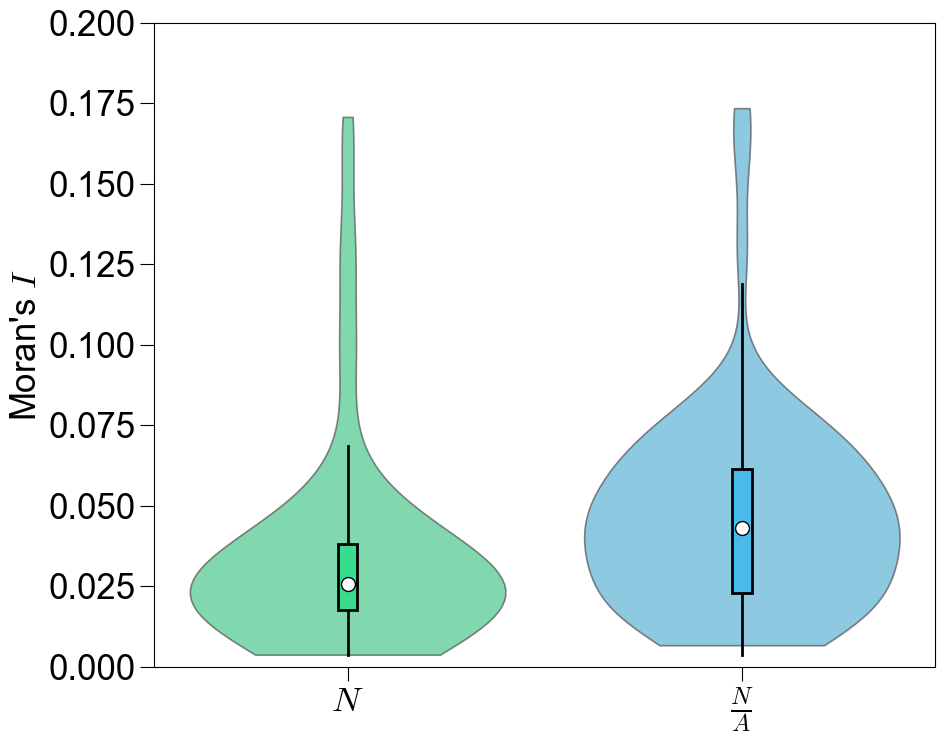

In [47]:
# Add annotation

# df_moran = pd.DataFrame({
#     "I": moranI_SAMIs + moranI_FAMIs + moranI_SAMIs_density + moranI_FAMIs_density ,
#     # "p": SAMIsFAMIs_pval + SAMIsFAMIs_density_pval,
#     "Type": [r"$\xi$"] * len(moranI_SAMIs) + [r"$\zeta$"] * len(moranI_FAMIs) \
#         + [r"$\xi$"] * len(moranI_SAMIs_density)  + [r"$\zeta$"] * len(moranI_FAMIs_density)
# })

colorsss = ["#39dc8d", '#4bbaea',"#39dc8d", '#4bbaea',]
df_moran = pd.DataFrame({
    "I": moranI_SAMIs + moranI_SAMIs_density ,

    "p": moranpsim_SAMIs + moranpsim_SAMIs_density ,
    "Group": [r"$N$"] * (len(moranI_SAMIs) ) + [r"$\frac{N}{A}$"] * (len(moranI_SAMIs_density)),
    # "Model": ["Original"] * len(moranI_SAMIs) 
    #         + ["Original"] * len(moranI_SAMIs_density) 
})



# df_moran["All"] = "Combined"

# --- PLOT ---
fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams.update({
    'font.size' : 25,
    "lines.linewidth": 2,
    'lines.markersize':10,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "it",    
    "mathtext.rm"  : "arial",
        })
sns.violinplot(
    x="Group", y="I", data=df_moran,
    palette={r"$N$": "#39dc8d", r"$\frac{N}{A}$": "#4bbaea"},
    inner=None,
    linewidth=1.2,
    ax=ax ,
    alpha=0.7,
    cut=0
    # split=True
)

group_stats = df_moran.groupby(['Group',])["I"].agg(
    q1=lambda x: x.quantile(0.25),
    q3=lambda x: x.quantile(0.75),
    median='median',
    min='min',
    max='max'
).reset_index()

iqr = group_stats['q3'] - group_stats['q1']
group_stats['lower_whisker'] = group_stats['q1'] - 1.5 * iqr
group_stats['upper_whisker'] = group_stats['q3'] + 1.5 * iqr

# Map Group and Model to position
hue_order = ["Original", "Extended"]
group_order = df_moran["Group"].unique()
positions = {}
for i, group in enumerate(group_order):
    for j, model in enumerate(hue_order):
        positions[(group, model)] = i - 0.2 + j * 0.4  # Adjust to match hue dodge spacing

# Add custom box per violin
box_width = 0.05
for idx, row in group_stats.iterrows():
    group_name = row['Group']
    pos = group_order.tolist().index(group_name)
    # Box (Q1–Q3)
    ax.add_patch(Rectangle(
        (pos - box_width / 2, row['q1']),
        box_width,
        row['q3'] - row['q1'],
        facecolor=colorsss[idx],
        edgecolor='black',
        linewidth=2,
        zorder=10
    ))

    # Median line
    ax.scatter(pos, row['median'],
            color='white', edgecolor='black', s=100, zorder=10)

    # Whiskers
    ax.plot([pos, pos], [max(row['lower_whisker'], df_moran['I'].min()), row['q1']],
            color='black', linewidth=2, zorder=9)
    ax.plot([pos, pos], [row['q3'], min(row['upper_whisker'], df_moran['I'].max())],
            color='black', linewidth=2, zorder=9)

# sns.stripplot(
#     x="Group", y="I", data=df_moran,
#     palette={r"$N$": "#39dc8d", r"$\frac{N}{A}$": "#4bbaea"},
#     #  cut=0, linewidth=1.5,  /split=True
#     jitter=True, 
#     # dodge=True,
#     alpha=0.6,
#     edgecolor='black',
#     linewidth=1,
#     size=10,
#     legend=False
# )

# Style
# plt.axhline(0, linestyle='--', color='gray')
plt.ylim(0, 0.2)
plt.yticks(size=20)
plt.xticks(size=20)
plt.ylabel(r"Moran's $I$",)
plt.xlabel("")
plt.tick_params(axis='x', labelsize=25, length=10)
plt.tick_params(axis='y', labelsize=25, length=10)
plt.legend(title="", loc="upper right", frameon=False)
plt.tight_layout()
# plt.savefig("./spatial_analysis.pdf", dpi=300, bbox_inches='tight')

plt.show()


In [56]:
print(sum(np.array(moranpsim_SAMIs)>=0.05)/len(moranpsim_SAMIs))
print(sum(np.array(moranpsim_SAMIs_density)>=0.05)/len(moranpsim_SAMIs_density))

print(sum(np.array(moranpsim_FAMIs)>=0.05)/len(moranpsim_FAMIs))
print(sum(np.array(moranpsim_FAMIs_density)>=0.05)/len(moranpsim_FAMIs_density))

0.16
0.08
0.16
0.17333333333333334


In [107]:
def scaling_figure(x0,y0,name,color):
    # print(len(x0))
    samis = Get_SAMIs(x0,y0)
    # print("SAMIs = ",samis)
    # print("Var = ",np.round(np.var(samis),2))
    x = np.log(x0)
    Y = np.log(y0)
    X = sm.add_constant(x)
    model = sm.OLS(Y,X)
    fit = model.fit(cov_type='HC1')
    # print(fit.summary())
        
    intercept, slope = fit.params
    # print("intercept = ", np.round(intercept,2))
    # print("c = ", np.round(np.exp(intercept),3))

    x_0 =  np.sort(x0)[0]
    y_0 = np.exp(slope*np.log(x_0)+intercept)

    x_f = np.sort(x0)[-1]
    y_f = np.exp(slope*np.log(x_f)+intercept)
    y_null = np.exp(np.log(x_f)+intercept)

    betta = round(slope,4)
    R2 = str(round(fit.rsquared,2))
    # print(R2)
    # R2 = str(round(fit.pvalues[1],3))
    beta_lowerbound, beta_upper = fit.conf_int().iloc[1]
    beta_lowerbound = np.round(beta_lowerbound,3)
    beta_upper = np.round(beta_upper,3)


    plt.rcParams.update({
    'font.size' : 20,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })

    fig,(ax)  = plt.subplots(1, 1, sharey='row',figsize=(8, 8))
    ax.scatter(x0, y0, facecolors=color, edgecolors='k',s=50) ## #b0c4b1,#f1b53b,#B696B6,#E6CECF,#C9DCC4,#C5DFF4,#7DA6C6,#B7B2D0,#EAAA60,#E68B81,#B36A6F,#508AB2,#D5BA82,#A1D0C7,#F0BB41,#a17db4,#ada579,#b3d6ad,#d6bbc1,#98A1B1,#F0E6E4,#d4d4d4
    ax.plot([x_0,x_f],[y_0,y_f], lw = 5, color = color,label=r'$\beta = {}$'.format("{:.3f}".format(betta))+r'$ \, \in \,[{}$'.format(beta_lowerbound) + r'$,{}]$'.format(beta_upper)+r', $\mathit{R}^2 = $' +r'${}$'.format(str(R2)))
    ax.plot([x_0,x_f],[y_0,y_null],lw=3,color='#C52A20',linestyle='--',label=r'$\beta=1$')
    # ax.hlines(y = y_0, xmin=x_0,xmax=x_f,linestyle = '--', color="#C52A20") ## #934833
    # ax.set_xlim([10**4,10**8])
    # ax.set_ylim([10**1,10**7])
    # ax.text(0.05,0.95,r'$\beta = {}$'.format("{:.2f}".format(betta))+r'$ \, \in \,[{}$'.format(beta_lowerbound) + r'$,{}]$'.format(beta_upper)+r', $\mathit{R}^2 = $' +r'${}$'.format(R2),
    #         ha='left', va='top',transform=ax.transAxes)
    # ax.text(0.05,0.85,r'$\mathit{R}^2 = $' +r'${}$'.format(R2), ha='left', va='top',transform=ax.transAxes)
    # ax.text(0.05,0.85,r'$\mathit{p} = $' +r'${}$'.format(R2), ha='left', va='top',transform=ax.transAxes)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("{}".format(str(x0.name)))
    ax.set_ylabel(name)
    ax.legend( loc='upper left',frameon=False)

    x = np.log(x0)
    Y = np.log(y0/x0)
    X = sm.add_constant(x)
    model = sm.OLS(Y,X)
    fit2 = model.fit(cov_type='HC1')
    intercept2, slope2 = fit2.params
    print("intercept = ", np.round(intercept2,2))
    print("c = ", np.round(np.exp(intercept2),3))
    x_0 =  np.sort(x0)[0]
    y_0 = np.exp(slope2*np.log(x_0)+intercept2)
    x_f = np.sort(x0)[-1]
    y_f = np.exp(slope2*np.log(x_f)+intercept2)
    y_null = np.exp(np.log(x_f)+intercept2)

    # ax.set_yticks([0.1,1,10**1,10**2,10**3,10**4], minor=True)
    l, b, h, w = .53, .19, .2, .32
    ax2 = fig.add_axes([l, b, w, h])
    ax2.scatter(x0, y0/x0, facecolors=color, edgecolors='k',s=50) ## #B36A6F,#508AB2,#D5BA82,#A1D0C7,#F0BB41,#a17db4,#ada579,#b3d6ad,#d6bbc1,#98A1B1
    ax2.plot([x_0,x_f],[y_0,y_f], lw = 5, color = color)
    ax2.hlines(y = y_0, xmin=x_0,xmax=x_f,linestyle = '--',lw=3, color="#C52A20") ## #934833
    ax2.set_xscale("log")
    # ax2.set_xticks([10**4,10**6,10**8])
    # ax2.set_ylim([0,.004])
    # ax2.set_ylabel(r"{} \n per capita".format(name))
    ax2.set_ylabel('per-capita')


    
    # ax.set_xticks([10**4,10**5,10**6,10**7,10**8], minor=True)
    # plt.savefig("{}.pdf".format(name),dpi=300, bbox_inches='tight')
    plt.show()
    return fit.conf_int().iloc[1,:],samis,betta,float(R2)

intercept =  -5.36
c =  0.005


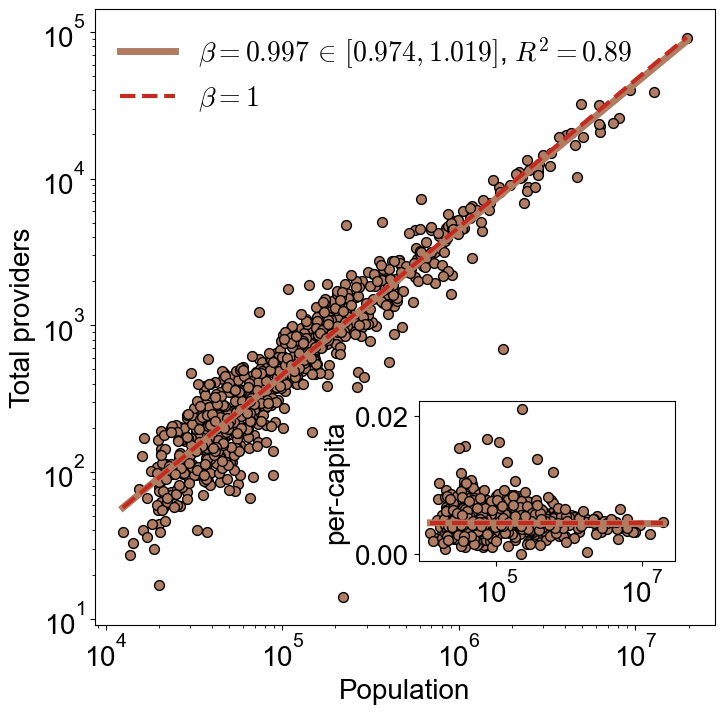

intercept =  5.06
c =  157.969


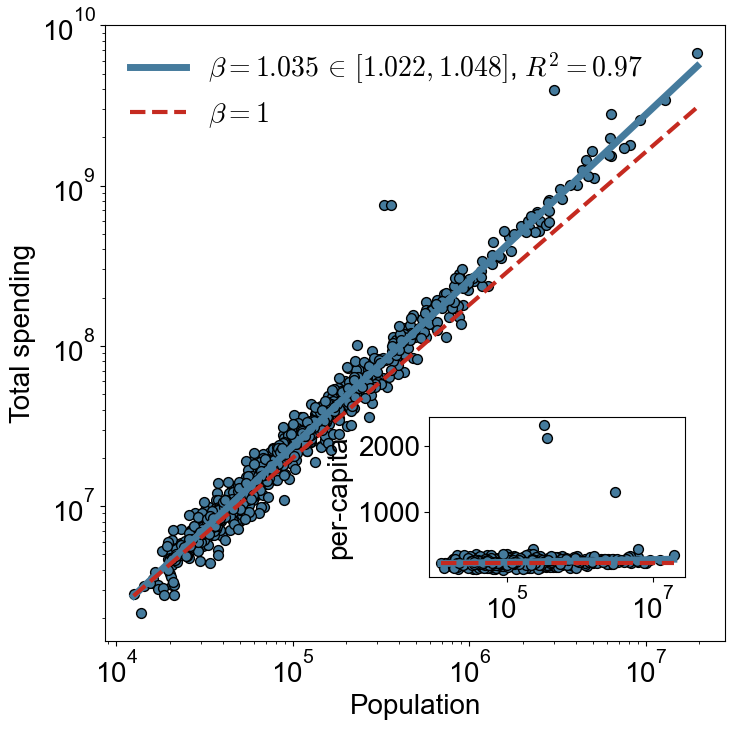

intercept =  15.04
c =  3388830.53


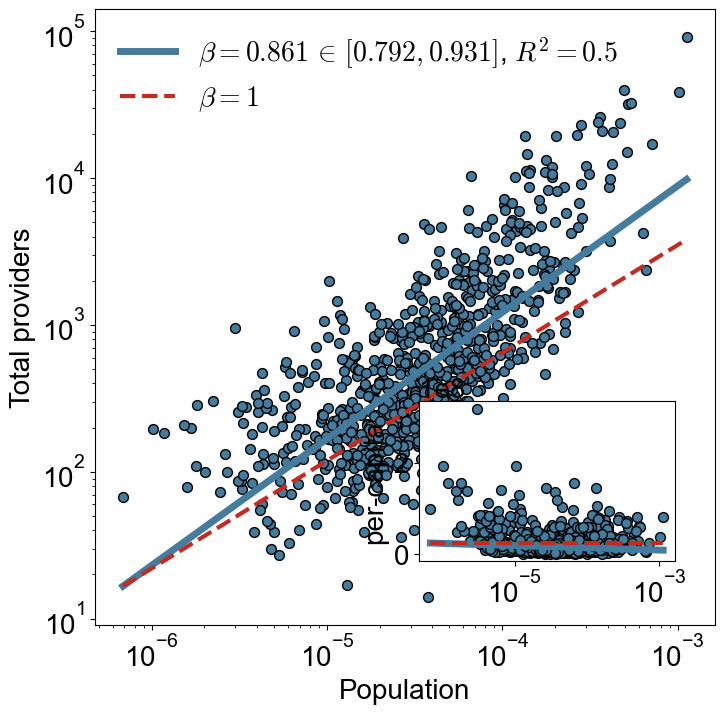

In [62]:
CIs, SAMIs_provider, beta, R2 = scaling_figure(cbsa_new["Population"],cbsa_new["TOTAL_PROVIDER"],'Total providers'.format(i),'#b07d62')
CIs, SAMIs_spending, beta, R2 = scaling_figure(cbsa_new["Population"],cbsa_new["spend_mean"],'Total spending'.format(i),'#457b9d')

CIs, SAMIs_spending, beta, R2 = scaling_figure(cbsa_new["Population_density"],cbsa_new["TOTAL_PROVIDER"],'Total providers'.format(i),'#457b9d')

In [91]:
cbsa_all.columns.tolist()

['cbsacode',
 'geometry',
 'cbsatitle',
 'GDP_2019',
 'ADDICTION MEDICINE',
 'ADULT CONGENITAL HEART DISEASE (ACHD)',
 'ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY',
 'ALLERGY/IMMUNOLOGY',
 'ANESTHESIOLOGY',
 'ANESTHESIOLOGY ASSISTANT',
 'CARDIAC ELECTROPHYSIOLOGY',
 'CARDIAC SURGERY',
 'CARDIOVASCULAR DISEASE (CARDIOLOGY)',
 'CERTIFIED CLINICAL NURSE SPECIALIST (CNS)',
 'CERTIFIED NURSE MIDWIFE (CNM)',
 'CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)',
 'CHIROPRACTIC',
 'CLINICAL PSYCHOLOGIST',
 'CLINICAL SOCIAL WORKER',
 'COLORECTAL SURGERY (PROCTOLOGY)',
 'CRITICAL CARE (INTENSIVISTS)',
 'DENTAL ANESTHESIOLOGY',
 'DENTIST',
 'DERMATOLOGY',
 'DIAGNOSTIC RADIOLOGY',
 'EMERGENCY MEDICINE',
 'ENDOCRINOLOGY',
 'ENDODONTICS',
 'FAMILY PRACTICE',
 'GASTROENTEROLOGY',
 'GENERAL PRACTICE',
 'GENERAL SURGERY',
 'GERIATRIC MEDICINE',
 'GERIATRIC PSYCHIATRY',
 'GYNECOLOGICAL ONCOLOGY',
 'HAND SURGERY',
 'HEMATOLOGY',
 'HEMATOLOGY/ONCOLOGY',
 'HEMATOPOIETIC CELL TRANSPLANTATION AND CELLULAR 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


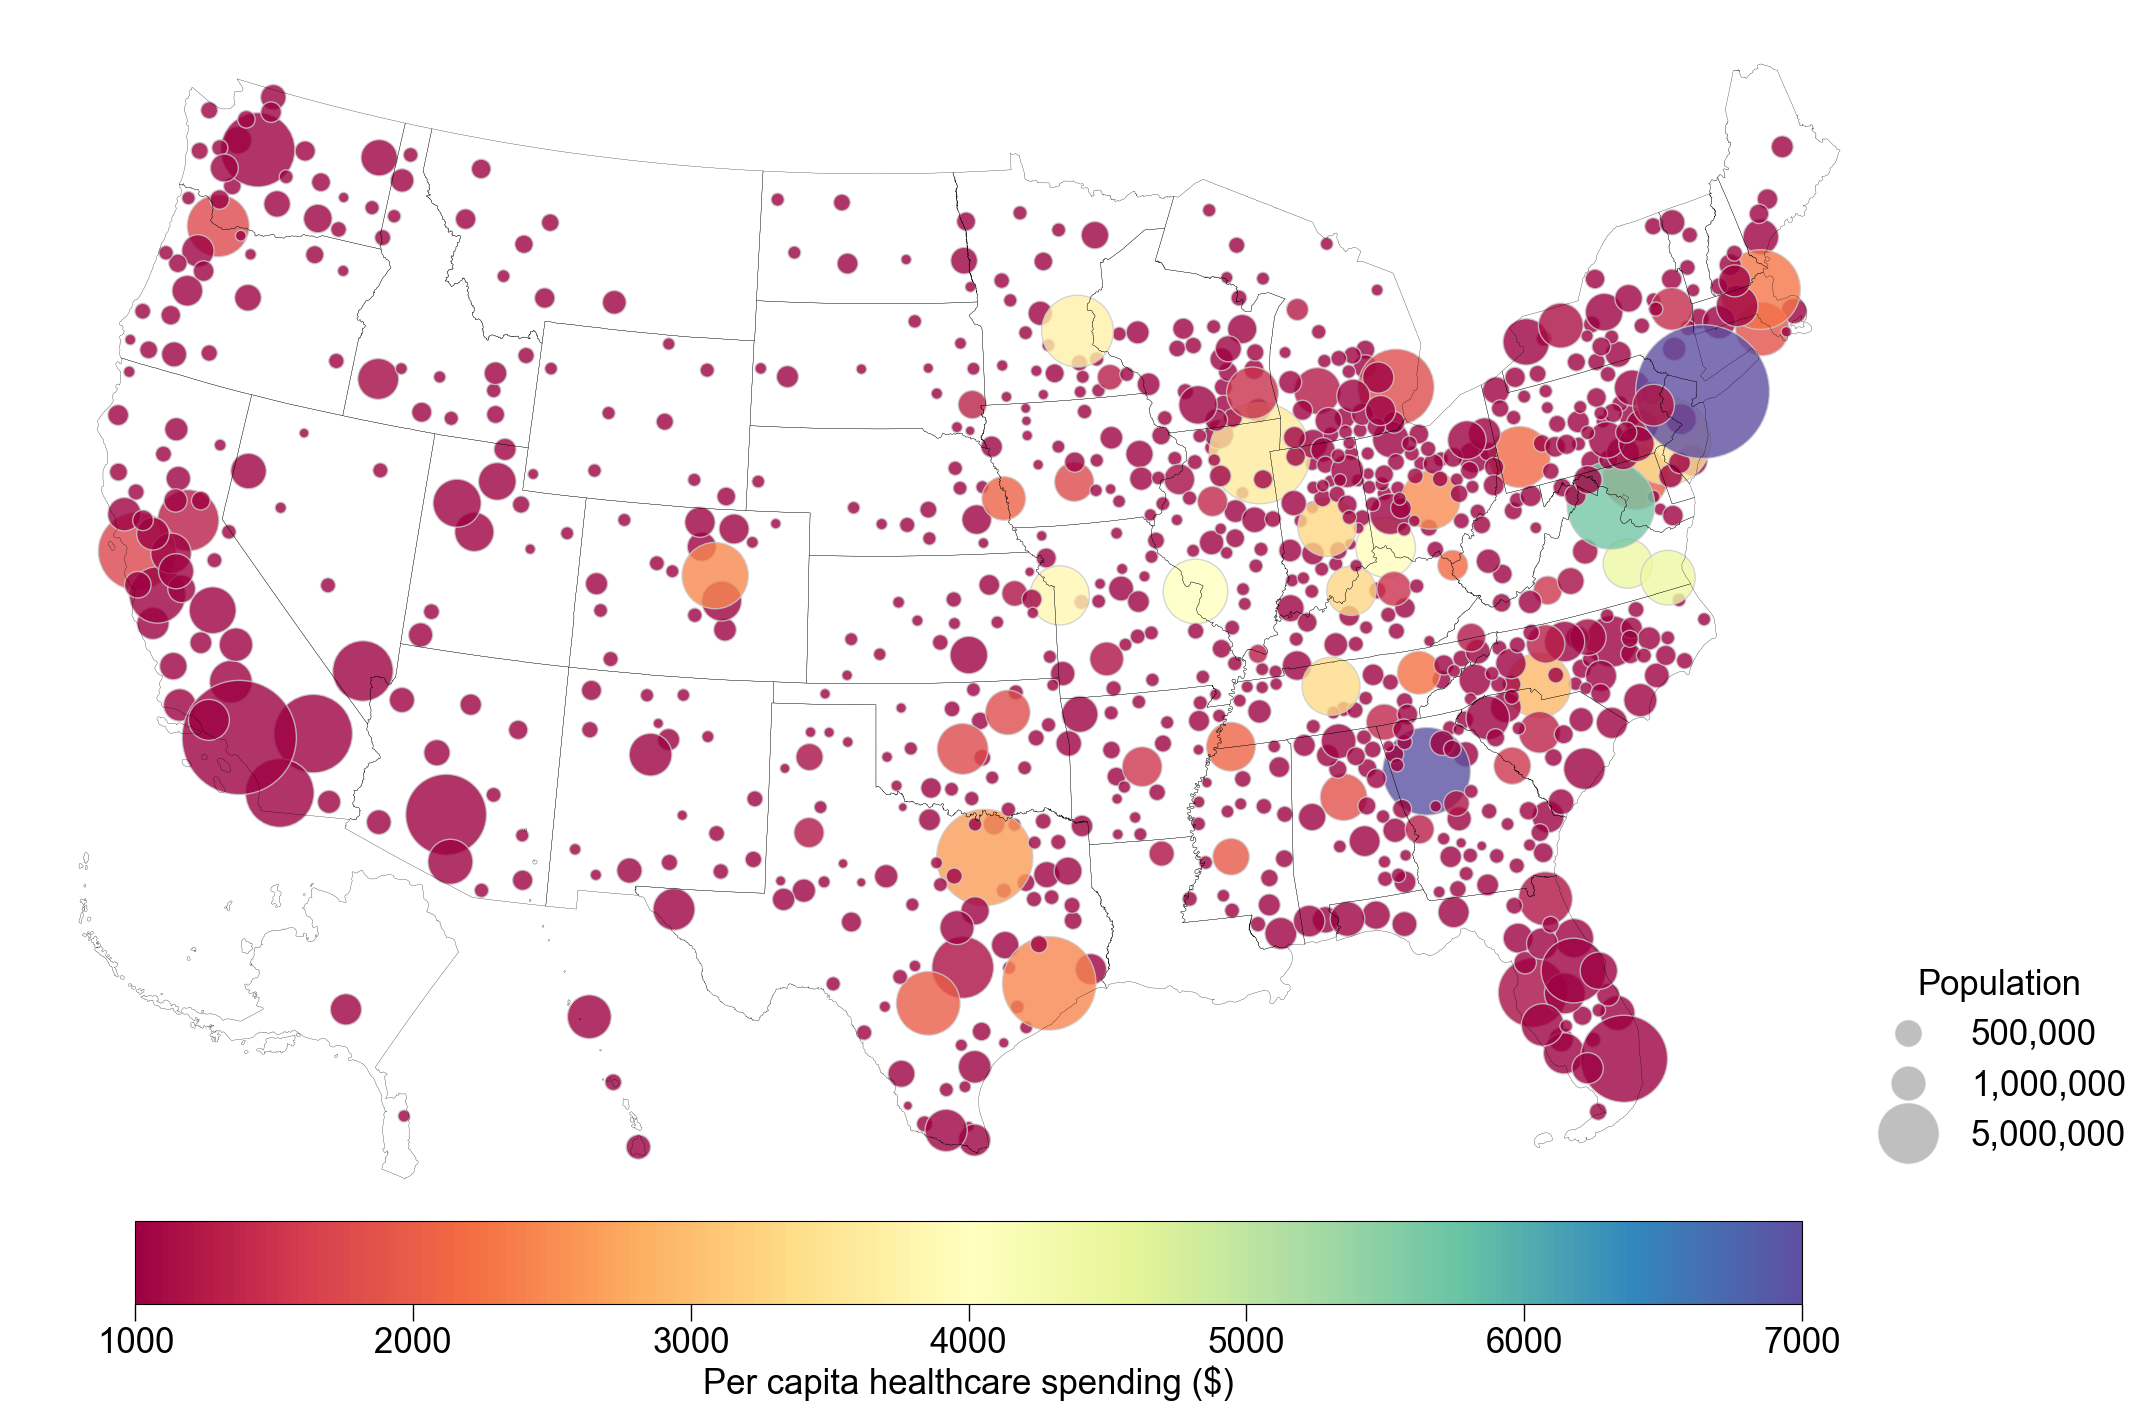

In [92]:
# df.plot()
cbsa_all['State'] = [s[-2:] for s in cbsa_all['cbsatitle']]

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from shapely.affinity import scale, translate
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# --- Settings ---
plt.rcParams.update({
    'font.size': 25,
    'lines.linewidth': 2,
    'font.family': 'arial',
    'mathtext.fontset': 'cm',
    'mathtext.default': 'it',
    'mathtext.it': 'arial',
})

# --- CRS Projection ---
df_count_category = cbsa_all.copy()
df_count_category = df_count_category.to_crs({'init': 'epsg:2163'})
state_shape = state_shape.to_crs({'init': 'epsg:2163'})

# --- Filter states present in data ---
state_shape = state_shape[state_shape['STUSPS'].isin(df_count_category['State'].unique())]

# --- Define variable and colormap ---
variable = 'spend_per_capita_mean'
# vmin = df_count_category.spend_per_capita_mean.min()
# vmax = df_count_category.spend_per_capita_mean.max()
vmin = 1000; vmax = 7000
cmap = sns.color_palette("Spectral", as_cmap=True)

# --- Separate regions ---
mainland = df_count_category[~df_count_category['State'].isin(['AK', 'HI'])]
alaska = df_count_category[df_count_category['State'] == 'AK'].copy()
hawaii = df_count_category[df_count_category['State'] == 'HI'].copy()

mainland_states = state_shape[~state_shape['STUSPS'].isin(['AK', 'HI'])]
alaska_state = state_shape[state_shape['STUSPS'] == 'AK'].copy()
hawaii_state = state_shape[state_shape['STUSPS'] == 'HI'].copy()

# --- Plot Base Map ---
fig, ax = plt.subplots(figsize=(22, 14), constrained_layout=True)
ax.axis('off')
mainland_states.boundary.plot(ax=ax, color='black', linewidth=0.2)

# --- Generate Point Geometry & Scale ---
df_count_category['centroid'] = df_count_category.geometry.centroid
gdf_points = df_count_category.set_geometry('centroid')

# Normalize population for marker size using square root scaling
size_factor = 1e2
gdf_points['marker_size'] = (gdf_points['Population'] / size_factor)**.75


# --- Plot Mainland Points ---
gdf_points[~gdf_points['State'].isin(['AK', 'HI'])].plot(
    ax=ax,
    markersize=gdf_points.loc[~gdf_points['State'].isin(['AK', 'HI']), 'marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8',
    alpha=0.8
)

# --- Alaska Inset ---
alaska.geometry = alaska.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
alaska_state.geometry = alaska_state.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
ak_ax = ax.inset_axes([0.01, 0.01, 0.25, 0.3])
ak_ax.axis('off')
alaska_state.boundary.plot(ax=ak_ax, color='black', linewidth=0.2)
gdf_points_ak = gdf_points[gdf_points['State'] == 'AK'].copy()
gdf_points_ak.geometry = gdf_points_ak.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
gdf_points_ak.plot(
    ax=ak_ax,
    markersize=gdf_points_ak['marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8', alpha=0.8
)

# --- Hawaii Inset ---
hawaii.geometry = hawaii.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
hawaii_state.geometry = hawaii_state.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
hi_ax = ax.inset_axes([0.15, 0.03, 0.3, 0.3])
hi_ax.axis('off')
hawaii_state.boundary.plot(ax=hi_ax, color='black', linewidth=0.2)
gdf_points_hi = gdf_points[gdf_points['State'] == 'HI'].copy()
gdf_points_hi.geometry = gdf_points_hi.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
gdf_points_hi.plot(
    ax=hi_ax,
    markersize=gdf_points_hi['marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8', alpha=0.8
)

# --- Colorbar ---
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", shrink=0.8, pad=0.01)
cbar.set_label(r'Per capita healthcare spending ($)')
cbar.ax.tick_params(labelsize=25, length=12, width=1)

# --- Population Legend ---
legend_pop_sizes = [5e5, 1e6, 5e6]
legend_markers = [(p / size_factor)**.7 for p in legend_pop_sizes]
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f'{int(p):,}',
           markerfacecolor='grey',
           markersize=np.sqrt(area),  # Convert area to diameter
           alpha=0.5)
    for p, area in zip(legend_pop_sizes, legend_markers)
]

ax.legend(handles=legend_elements, title='Population',
          loc='lower right', bbox_to_anchor=(1.12, 0.02),
          frameon=False, fontsize=25, title_fontsize=25)

# --- Save ---
# plt.savefig("./Map_spending.pdf", dpi=300, bbox_inches='tight')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


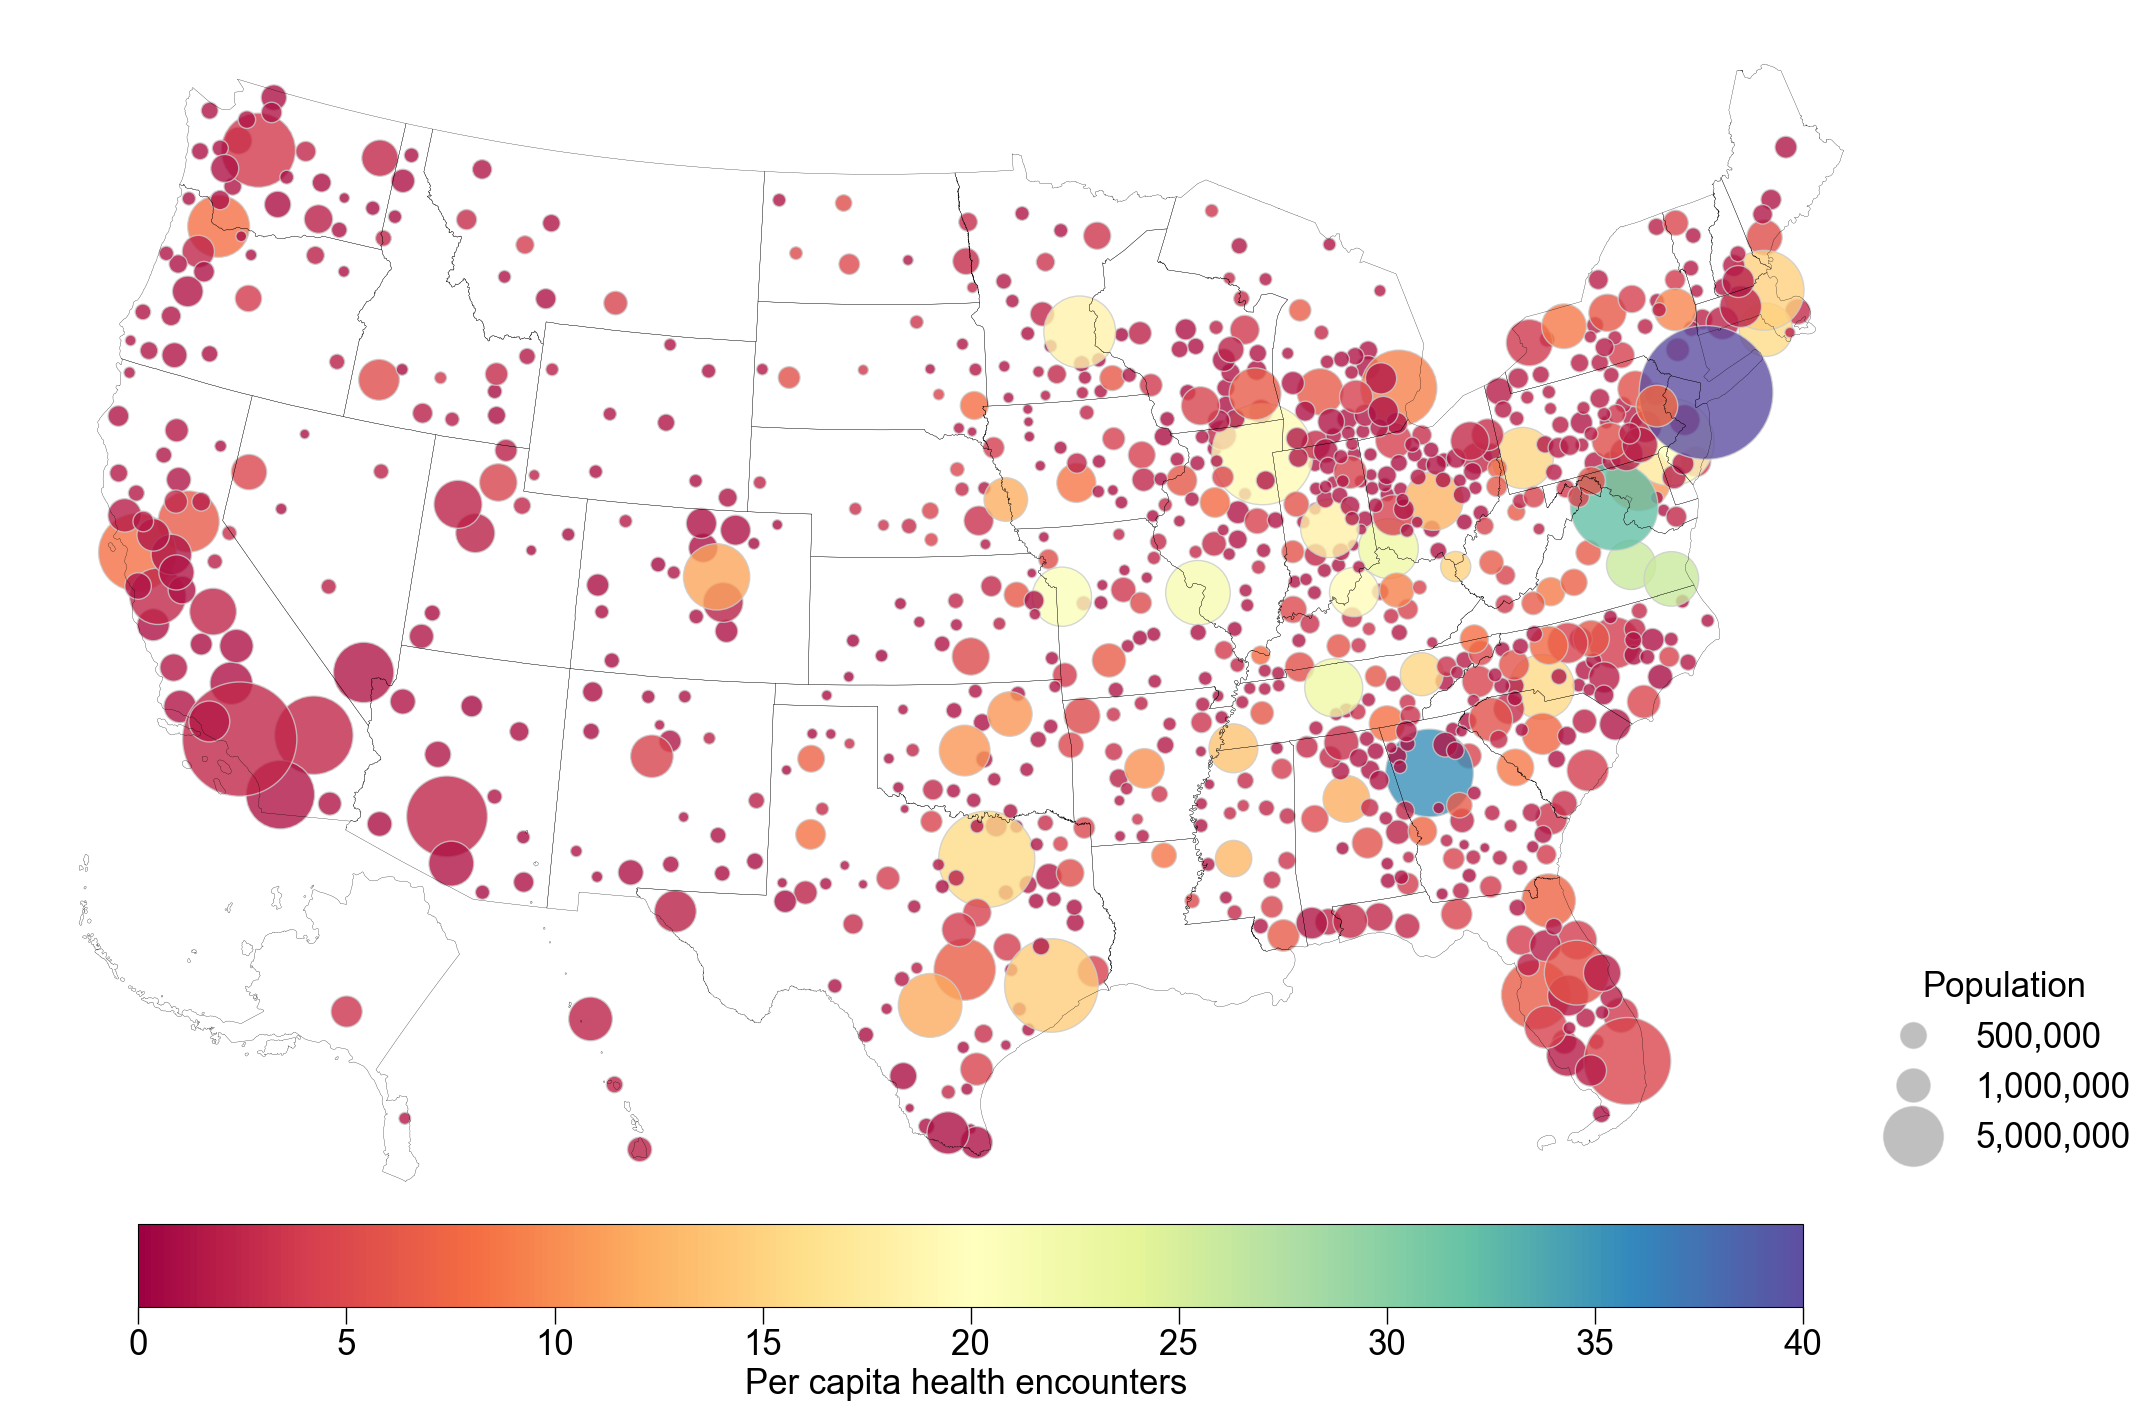

In [94]:
# df.plot()

# cbsa_new['State'] = [s[-2:] for s in cbsa_new['cbsatitle']]
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from shapely.affinity import scale, translate
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# --- Settings ---
plt.rcParams.update({
    'font.size': 25,
    'lines.linewidth': 2,
    'font.family': 'arial',
    'mathtext.fontset': 'cm',
    'mathtext.default': 'it',
    'mathtext.it': 'arial',
})

# --- CRS Projection ---
# df_count_category = cbsa_new.copy()
df_count_category = df_count_category.to_crs({'init': 'epsg:2163'})
state_shape = state_shape.to_crs({'init': 'epsg:2163'})

# --- Filter states present in data ---
state_shape = state_shape[state_shape['STUSPS'].isin(df_count_category['State'].unique())]

# --- Define variable and colormap ---
variable = 'vol_per_capita_mean'
vmin = df_count_category.vol_per_capita_mean.min()
vmax = df_count_category.vol_per_capita_mean.max()
vmin = 0; vmax = 40
cmap = sns.color_palette("Spectral", as_cmap=True)

# --- Separate regions ---
mainland = df_count_category[~df_count_category['State'].isin(['AK', 'HI'])]
alaska = df_count_category[df_count_category['State'] == 'AK'].copy()
hawaii = df_count_category[df_count_category['State'] == 'HI'].copy()

mainland_states = state_shape[~state_shape['STUSPS'].isin(['AK', 'HI'])]
alaska_state = state_shape[state_shape['STUSPS'] == 'AK'].copy()
hawaii_state = state_shape[state_shape['STUSPS'] == 'HI'].copy()

# --- Plot Base Map ---
fig, ax = plt.subplots(figsize=(22, 14), constrained_layout=True)
ax.axis('off')
mainland_states.boundary.plot(ax=ax, color='black', linewidth=0.2)

# --- Generate Point Geometry & Scale ---
df_count_category['centroid'] = df_count_category.geometry.centroid
gdf_points = df_count_category.set_geometry('centroid')

# Normalize population for marker size using square root scaling
size_factor = 1e2
gdf_points['marker_size'] = (gdf_points['Population'] / size_factor)**.75


# --- Plot Mainland Points ---
gdf_points[~gdf_points['State'].isin(['AK', 'HI'])].plot(
    ax=ax,
    markersize=gdf_points.loc[~gdf_points['State'].isin(['AK', 'HI']), 'marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8',
    alpha=0.8
)

# --- Alaska Inset ---
alaska.geometry = alaska.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
alaska_state.geometry = alaska_state.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
ak_ax = ax.inset_axes([0.01, 0.01, 0.25, 0.3])
ak_ax.axis('off')
alaska_state.boundary.plot(ax=ak_ax, color='black', linewidth=0.2)
gdf_points_ak = gdf_points[gdf_points['State'] == 'AK'].copy()
gdf_points_ak.geometry = gdf_points_ak.geometry.scale(xfact=1.3, yfact=1.3, origin=(0, 0)).translate(xoff=1800000, yoff=-3200000)
gdf_points_ak.plot(
    ax=ak_ax,
    markersize=gdf_points_ak['marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8', alpha=0.8
)

# --- Hawaii Inset ---
hawaii.geometry = hawaii.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
hawaii_state.geometry = hawaii_state.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
hi_ax = ax.inset_axes([0.15, 0.03, 0.3, 0.3])
hi_ax.axis('off')
hawaii_state.boundary.plot(ax=hi_ax, color='black', linewidth=0.2)
gdf_points_hi = gdf_points[gdf_points['State'] == 'HI'].copy()
gdf_points_hi.geometry = gdf_points_hi.geometry.scale(xfact=10.0, yfact=10.0, origin=(0, 0)).translate(xoff=5000000, yoff=-2800000)
gdf_points_hi.plot(
    ax=hi_ax,
    markersize=gdf_points_hi['marker_size'],
    column=variable,
    cmap=cmap, vmin=vmin, vmax=vmax,
    edgecolor='0.8', alpha=0.8
)

# --- Colorbar ---
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", shrink=0.8, pad=0.01)
cbar.set_label(r'Per capita health encounters ')
cbar.ax.tick_params(labelsize=25, length=12, width=1)

# --- Population Legend ---
legend_pop_sizes = [5e5, 1e6, 5e6]
legend_markers = [(p / size_factor)**.7 for p in legend_pop_sizes]
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f'{int(p):,}',
           markerfacecolor='grey',
           markersize=np.sqrt(area),  # Convert area to diameter
           alpha=0.5)
    for p, area in zip(legend_pop_sizes, legend_markers)
]


ax.legend(handles=legend_elements, title='Population',
          loc='lower right', bbox_to_anchor=(1.12, 0.02),
          frameon=False, fontsize=25, title_fontsize=25)

# --- Save ---
# plt.savefig("./Map_encounter.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [95]:
cbsa_new

,Unnamed: 0,cbsacode,cbsatitle,year_id,spend_mean,spend_per_capita_mean,vol_mean,vol_per_capita_mean,STUSPS,CSAFP,...,Population_log,GDP_PERCAPITA,PROVIDER_log,econ_cluster_named,state_index,ENCOUNTER_PERCAPITA,ENCOUNTER_PERGDP,ENCOUNTER_PERPROVIDER,SAMIs_provider,SAMIs_spending
0,0,10100,"Aberdeen, SD",2019.0,1.096086e+07,540.707857,6.621889e+07,3483.083571,SD,NaN,...,10.640412,57987.078248,5.786897,$316,0,1584.563056,27.326141,203125.429798,0.539145,0.133368
1,1,10140,"Aberdeen, WA",2019.0,1.701542e+07,225.572500,8.579833e+07,1163.067500,WA,NaN,...,11.255320,34905.382326,5.497168,$316,1,1110.083147,31.802635,351632.485277,-0.363344,-0.063344
2,2,10180,"Abilene, TX",2019.0,3.453346e+07,620.445357,1.639302e+08,3940.628929,TX,NaN,...,12.109512,42910.766503,6.923629,$316,2,902.744289,21.037711,161348.659599,0.211906,-0.239724
3,3,10220,"Ada, OK",2019.0,8.390485e+06,220.290357,4.892607e+07,1274.614286,OK,NaN,...,10.555709,54704.396291,5.978886,$316,3,1274.249124,23.293359,123863.466727,0.815542,-0.046186
4,4,10300,"Adrian, MI",2019.0,2.825124e+07,283.534643,1.481013e+08,1506.472857,MI,220.0,...,11.487813,31290.155865,5.958425,$316,4,1518.676647,48.535285,382690.818051,-0.133769,0.203016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,49660,"Youngstown-Warren, OH",2019.0,1.190462e+08,553.321786,6.602351e+08,3097.936429,OH,566.0,...,12.962122,40421.744305,7.541683,$316,5,1549.960472,38.344720,350257.353987,-0.019672,0.115308
841,841,49700,"Yuba City, CA",2019.0,4.001998e+07,444.988571,2.261617e+08,2590.823214,CA,472.0,...,12.120896,38656.677737,6.287859,$316,25,1231.347910,31.853433,420374.852544,-0.435208,-0.104058
842,842,49740,"Yuma, AZ",2019.0,3.939104e+07,179.212143,2.076296e+08,979.703571,AZ,NaN,...,12.270084,37370.840583,6.566672,$316,45,973.776305,26.057115,292024.694228,-0.305062,-0.274326
843,843,49780,"Zanesville, OH",2019.0,1.959898e+07,226.992500,1.080270e+08,1255.646071,OH,198.0,...,11.365643,44573.883321,6.357842,$316,5,1251.688760,28.081214,187221.834425,0.387392,-0.036184


intercept =  0.16
c =  1.176


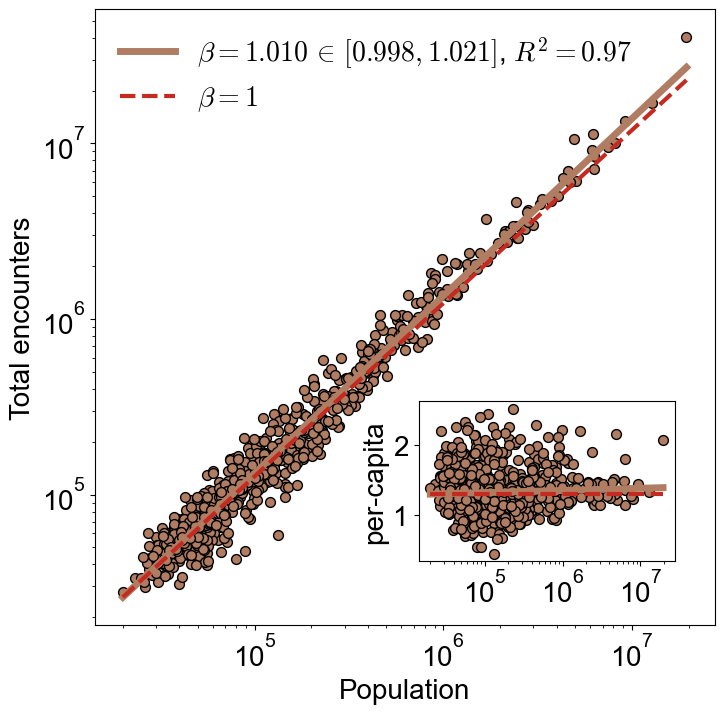

intercept =  21.09
c =  1449966043.805


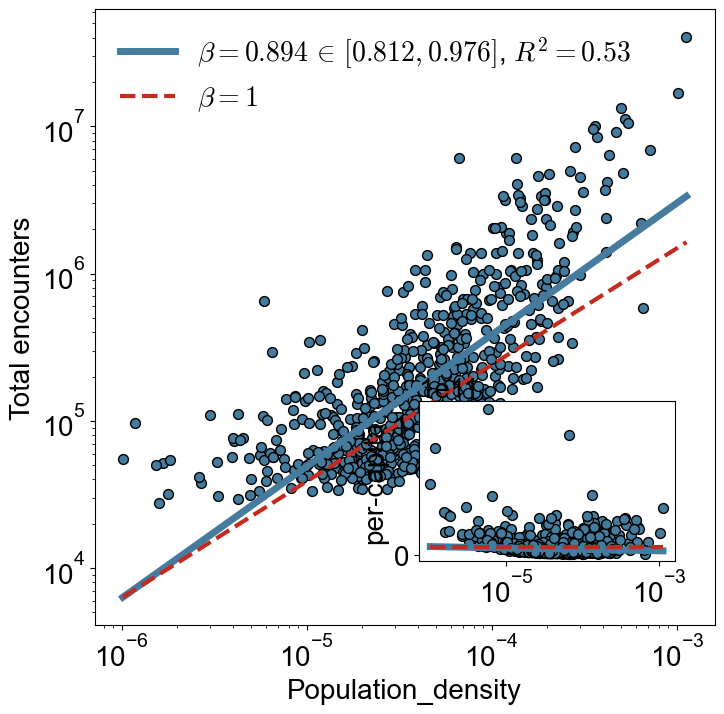

In [108]:
import statsmodels.api as sm
df = cbsa_all[cbsa_all['vol_mean']!=0]
CIs, SAMIs_provider, beta, R2 = scaling_figure(df["Population"],df["vol_mean"],'Total encounters'.format(i),'#b07d62')

CIs, SAMIs_spending, beta, R2 = scaling_figure(df["Population_density"],df["vol_mean"],'Total encounters'.format(i),'#457b9d')